## <strong> SafeML - A tool for safety monitoring of ML components </strong>

### <em>StaDRe and StaDRo </em>: Reliability and Robustness Estimation of ML-based Forecasting using Statistical Distance Measures

As technology moves toward higher degrees of automation in cars, the use of AI, and specifically Machine Learning (ML), becomes more common. The assurance of the safety of such systems is a huge problem, as they add new sources of risk into the system. SafeML is one of various risk-reduction approaches that has been proposed in:
<br>https://www.springerprofessional.de/en/safeml-safety-monitoring-of-machine-learning-classifiers-through/18346420</br>

SafeML method addresses safety and security during operation of ML systems by actively monitoring the distance between design-time trained context and runtime context using Empirical Cumulative Distribution Function (ECDF)- based distance measures.
The entire code of SafML is avaiable at: https://github.com/ISorokos/SafeML

Ensuring dependability of ML systems is crucial, particularly when deployed in safety-critical applications as the decisions based
on model predictions can result in hazardous situations. For ML-based systems to be used in safety-critical systems, certain qualities of
ML solutions such as reliability, fairness, robustness, transparency, and security are important.  

This work focuses on two quailities that are desired from ML solutions: <em>Reliability</em> and <em>Robustness</em> and uses SafeML for time series data. With this objective, distance measures based on ECDF proposed in SafeML are investigated for measuring Statistical-Distance Dissimilarity (SDD) across time series. We then present two novel metrics: SDD-based Reliability Estimate (StaDRe) and SDD-based Robustness (StaDRo).



<em>This notebook provides a runtime example for the computation of StaDRo. The example considered here is financial-critical i.e. company's stock closing price.</em>

The rest of the notebook is organized as follows:

<ol>
    <li>Data Acquisition, pre-processing, visualization and preparation. </li>
    <li>Model training (if built from scratch) or Loading a trained model </li>
    <li>Evaluation of model's performance at runtime</li>
    <li>Estimation of SDD between training and runtime environments</li>
    <li>SDD vs. Performance behaviour</li>
    <li>StaDRo measure</li>
</ol>

### Import necessary libraries

In [1]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from core.data_preparation import DataPreparation
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize, compute_roots_from_curve_fit, sdd_performance_visualization
from core.ecdf_distance_measures import WassersteinDistance, CramerVonMisesDistance, KuiperDistance, AndersonDarlingDistance, KolmogorovSmirnovDistance, DTSDistance

### Check the computing platform

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("PyTorch using device :", DEVICE)

PyTorch using device : cpu


### 1. Data Acquisition

First step in building a prediction module, is to get the historical data. Currently there exists number of apis that we can utilise to get the dataset. In this notebook we explore use of the following libraries getting Stock history.
<ul>
    <li> NSEpy </li>
    <li> Yahoo Finance </li>
</ul>


The closing price of a stock is recorded every day on weekdays. On weekends, no data is collected.

In [5]:
DATAFOLDERPATH = os.path.join(os.path.dirname(os.getcwd()), 'Data')

Using NSEpy - NSEpy is a library for National Stock Exchange of India.

In [6]:
from nsepy import get_history
from datetime import date

# Provide start and end dates for acquiring historical data
start_date = date(2010,1,1)
end_date = date.today()

# Get historical data for specific company by choosing specific symbol, in this case Reliance data.
data = get_history(symbol="RELIANCE", start=start_date, end=end_date)

# Now convert this data to Kaggle format so that we can use it in training and testing. The Kaggle accepts data in following format.
kaggle_filepath = os.path.join(DATAFOLDERPATH, 'Kaggle_sample.csv')
sample = pd.read_csv(kaggle_filepath)
print("The kaggle data should be in following format.")
sample.head()


The kaggle data should be in following format.


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [7]:
# Select the required columns for the new dataset and rename the columns to suit to Kaggle format.
new_dataset = data[['Open','High', 'Low', 'Close', 'Volume', 'Symbol']]
new_dataset.columns = ['Open','High', 'Low', 'Close', 'Volume', 'Name']

export_name = data["Symbol"][0]+ '_' + str(start_date) + str(end_date) + '.csv'
full_save_path = os.path.join(DATAFOLDERPATH, export_name)
new_dataset.to_csv(full_save_path)

Using Yahoo Finance

Yahoo Finance allows to download historical data from the following link - https://finance.yahoo.com/. Follow the below given steps:
<ul>
    <li> Click on the above link. </li>
    <li> Search for the company for which the data is to be acquired by typing the symbol or company name in the search bar. </li>
    <li> Click on Historical Data and select required start and end dates </li>
    <li> Finally, click on Download </li>
</ul>

The data provided by Yahoo Finace is already a match to Kaggle format except for the missing Name column. However, as we are only working with Closing price of the company's stock data over a certain period of time, we could use the dataset file acquired from Yahoo Finance as it is without converting it explicitly to Kaggle Format.

In [8]:
# Exceute the following block of code for converting data acquired from Yahoo Finance into Kaggle format (Optional).
symbol = 'Google'
filename = 'YahooFinance_Google_Example.csv'
filepath = os.path.join(DATAFOLDERPATH, filename)
data = pd.read_csv(filepath, header=0)

# Drop additional column Adj Close and add Name column
data.drop('Adj Close', axis=1, inplace=True)
data['Name'] = symbol

data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2021-06-01,2422.000000,2437.970947,2404.879883,2429.810059,958300,Google
1,2021-06-02,2435.310059,2442.000000,2404.199951,2421.280029,857900,Google
2,2021-06-03,2395.020020,2409.745117,2382.830078,2404.610107,917300,Google
3,2021-06-04,2422.520020,2453.858887,2417.770020,2451.760010,1297400,Google
4,2021-06-07,2451.320068,2468.000000,2441.072998,2466.090088,1192500,Google


In [9]:
# Read the dataset file from the Data directory, which is already acquired. 
# We use the RELIANCE company dataset until 30-08-2021 that was acquired at the time of implementation of the project in order to reproduce the presented results.
# However, any other datasets with different start and end dates can be used.

filepath = os.path.join(DATAFOLDERPATH, 'RELIANCE_2010-01-012021-08-30.csv')
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1075.50
1,2010-01-05,1070.70
2,2010-01-06,1088.00
3,2010-01-07,1106.05
4,2010-01-08,1103.15


In [10]:
# Check for the length of data and for any missing values. 
print("Length of the dataset:", len(data))
print("Are there any missing values:", data.isnull().values.any())

Length of the dataset: 2895
Are there any missing values: False


In [11]:
# Remove the entries with NaN and cross-check if these are additional data added on weekends or some weekday data is missing.
# Execute only if there are missing values.
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

### Visualize the univariate time series read from the .csv file
#### (Example: RELIANCE company's stock closing price)

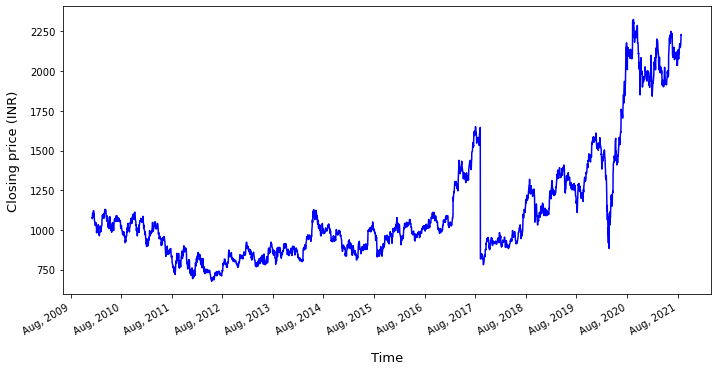

In [12]:
#Creates just a figure and only one subplot
fig, ax = plt.subplots(figsize=(9,5))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(data['date'], data['close'], c='b')
ax.set_xlabel('Time', fontsize=13, labelpad=15)
ax.set_ylabel('Closing price (INR)', fontsize=13,  labelpad=10)
half_year_locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(half_year_locator)
month_year_formatter = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(month_year_formatter)
fig.autofmt_xdate()
plt.show()

The stock price data for Reliance is collected from 01-01-2010 (start date) to 31-08-2021 (end date), resulting in a 2895-day time period. Looking at the data, it is visible that there is an increasing trend in the time series beginning around July 2020, and stock prices are rising year after year.

### Setup training and test phases

To forecast future values using forecasting methods, the entire dataset is split into training and test sets (hold-out). The training set is used to determine forecasting model parameters by fitting data to it, whereas the test set is used to assess the accuracy of this trained model. All datasets utilized in this work are split into two parts: 80% training and 20% testing. The closing price data is normalized between -1 and 1 for training and evaluating forecasting models. This work primarily focuses on univariate time series with <em>one-step </em> ahead prediction (i.e. forecast horizon = 1). The <em>window size</em> or <em>lookback period</em> are tuned differently for every use case. The example in this notebook considers a <em>window size of 20</em>.

In [13]:
# Define the length of training data, here 80% of the entire data is considered.
train_len = 0.8*len(data)

# Define window size or the lookback period to be used while forecasting time series.
window_size = 20

# Initialize data preparation with default test fraction and window size
dataset = DataPreparation()

# Divide the data intro training and test set with default values as 80% training data and 20% 
train_set, test_set = dataset.splitData(data['close'].values)

# Length of actual test set
actual_test_len = len(test_set) - window_size

# Define feature range for normalization of the data.
scaler = MinMaxScaler(feature_range=(-1, 1))

# Formulate time series into supervised learning problem using sliding window approach
scaler, x_train, x_test, y_train_lstm, y_test_lstm = dataset.prepare_data_with_normalization(data['close'].values, scaler)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


### Build and Train a forecasting model from scratch

For forecasting, any of the available deep learning architectures can be used. This work primarily focuses on LSTM and GRU models that models can be built and trained from scratch. For Reliance, the LSTM architecture was designed with two hidden layers and a hidden dimension of 32. The model was trained over 100 epochs using the Adam optimizer with mean squared error as the loss function. A learning rate of 0.01 was found to be optimal. 

In [14]:
# input_dim = 1
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# hist = np.zeros(num_epochs)
# lstm = []

# for t in range(num_epochs):
#     y_train_pred = model(x_train)

#     loss = criterion(y_train_pred, y_train_lstm)
#     hist[t] = loss.item()

#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()
    


### Save the trained model

In [15]:
# torch.save(model, 'lstm_rel.pt')

### (or) Load an already trained model and setup the mode to evaluation

Once an optimal model is trained and saved, the model can be loaded in future for further steps. After loading the model, set the model to evaluation mode.

In [16]:
full_model_path = os.path.join(os.path.dirname(os.getcwd()), 'trained_models', 'lstm_rel.pt')
model = torch.load(full_model_path)
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Predict on the hold-out dataset

Forecast accuracy must be evaluated in order to determine the quality of forecasts predicted by the model. Forecast errors must be calculated in order to determine forecast accuracy. In this work, forecasting errors are computed using several error metrics
<ul>
    <li>Root Mean Square Error (RMSE)</li>
    <li>Mean Absolute Percentage Error (MAPE)</li>    
</ul>

In this work, we also employ the coefficient of determination, often known as R2 or R-squared, which is a commonly used regression performance measure. 

In [17]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score')
print('MAPE: %.2f' % (test_error))
print(f'R-Squared: {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score
MAPE: 0.05
R-Squared: 0.8750267436432391
RMSE:  129.89433806944783


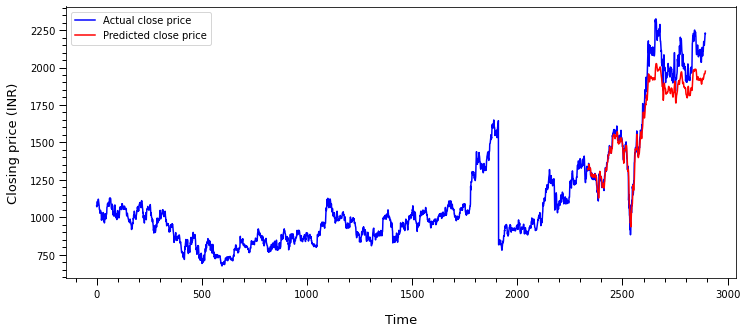

In [18]:
# Visualize entire dataset and predictions of the model on hold-out dataset
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data.index, data['close'], c='b', label='Actual close price')
ax.plot(data.index[-actual_test_len:], y_test_pred[:,0], c='r', label='Predicted close price')
ax.set_xlabel('Time', fontsize=13, labelpad=15)
ax.set_ylabel('Closing price (INR)', fontsize=13,  labelpad=10)
ax.tick_params(which='both', width=1, length=7)
ax.tick_params(which='minor', length=4)
plt.minorticks_on()
ax.legend(loc='best')
plt.show()


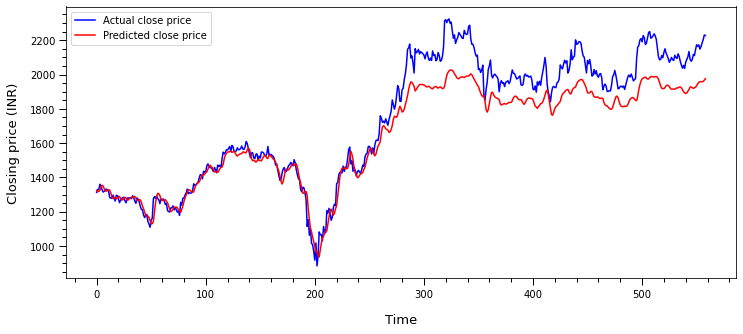

In [19]:
x_range = np.arange(0, len(y_test[:,0]))

# Visualize ground truth and predictions of the model on hold-out dataset
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x_range, y_test[:,0], c='b', label='Actual close price')
ax.plot(x_range, y_test_pred[:,0], c='r', label='Predicted close price')
ax.set_xlabel('Time', fontsize=13, labelpad=15)
ax.set_ylabel('Closing price (INR)', fontsize=13,  labelpad=10)
ax.tick_params(which='both', width=1, length=7)
ax.tick_params(which='minor', length=4)
plt.minorticks_on()
ax.legend(loc='best')
plt.show()


### Evaluate how performance of model varies with non-stationarity in hold-out dataset

In [20]:
def evaluate_performance_variation(subset_size: int):

    """This function evaluates performance of forecasting model over different subsets of hold-out dataset.

    :param: size of subsets considered for dividing hold-out dataset into several blocks.
    :type subset_size: int
    :return: Performance measures across different data instances.
    :rtype: DataFrame
    """    
    
    r2_list = []
    rmse_list = []
    mape_list = []
    dataset_range = []

    num_subsets = actual_test_len / subset_size

    if((math.ceil(num_subsets) - num_subsets) < 0.02):
        num_subsets = math.ceil(num_subsets)
    else:
        num_subsets = math.floor(num_subsets)
    
    for i in range(num_subsets):
    
        X1, X2 = gt[i*subset_size : (i+1)*subset_size], preds[i*subset_size : (i+1)*subset_size]

        rmse = math.sqrt(mean_squared_error(X1, X2))
        mape = mean_absolute_percentage_error(X1, X2)*100  #Convert the MAPE values to 0-100 from 0-1.
        r2 = r2_score(X1, X2)
        rmse_list.append(rmse)
        mape_list.append(mape)
        r2_list.append(r2)
        
        dataset_range.append(f'{i*subset_size} : {(i+1)*subset_size}')
    

    accuracy = { "Data Instance" : dataset_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R-Squared": r2_list
    }

    acc_df = pd.DataFrame(accuracy)

    return acc_df

In [21]:
acc_df_1 = evaluate_performance_variation(100)
acc_df_1

,Data Instance,RMSE,MAPE,R-Squared
0,0 : 100,27.891850,1.669585,0.810739
1,100 : 200,37.081407,1.970304,0.919765
2,200 : 300,103.022923,4.612120,0.906988
3,300 : 400,185.581729,8.164647,-1.370957
4,400 : 500,153.534866,7.069484,-2.091900


In [22]:
acc_df_2 = evaluate_performance_variation(70)
acc_df_2

,Data Instance,RMSE,MAPE,R-Squared
0,0 : 70,29.628983,1.749787,0.685558
1,70 : 140,26.856679,1.518385,0.952918
2,140 : 210,47.133102,2.755424,0.944063
3,210 : 280,63.627978,3.246228,0.902331
4,280 : 350,216.608491,9.647360,-4.736759
5,350 : 420,132.016948,6.219833,-5.616918
6,420 : 490,151.742606,7.126105,-2.444127
7,490 : 560,200.172318,9.120893,-7.141950


In [23]:
acc_df_3 = evaluate_performance_variation(50)
acc_df_3

,Data Instance,RMSE,MAPE,R-Squared
0,0 : 50,21.862279,1.466220,0.844714
1,50 : 100,32.832169,1.872950,0.785726
2,100 : 150,29.439387,1.586830,0.658086
3,150 : 200,43.397975,2.353779,0.921883
4,200 : 250,55.269046,3.517237,0.917531
5,250 : 300,134.806451,5.707004,0.557694
6,300 : 350,226.208784,9.980036,-7.274816
7,350 : 400,133.081712,6.349260,-8.686428
8,400 : 450,159.150755,7.250109,-1.768542
9,450 : 500,147.705610,6.888860,-2.896008


The results of the performance evaluation on test sets indicate that when more non-stationarities in the test set are introduced after the 250th time step, the model's fit begins to get arbitrarily poorer. This observation holds true for all three performance metrics: RMSE, MAPE, and R-Squared. 

The observed performance tendency is unaffected by changing the length of test subsets from 50 to 100.

### Evaluate SDD between training set and subsets of hold-out dataset

In [24]:
def get_statistical_dist_measures(X_train, X_test):  

    """Computes SDD between training set and hold-out sets using several ECDF-based distance measures

    :return: Statistical distance measures
    :rtype: Dictionary
    """     

    CVM_distance = CramerVonMisesDistance().compute_distance(X_train, X_test)
    Anderson_Darling_distance = AndersonDarlingDistance().compute_distance(X_train, X_test)
    Kolmogorov_Smirnov_distance = KolmogorovSmirnovDistance().compute_distance(X_train, X_test)
    Kuiper_distance = KuiperDistance().compute_distance(X_train, X_test)
    Wasserstein_distance = WassersteinDistance().compute_distance(X_train, X_test)
    DTS_distance = DTSDistance().compute_distance(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.    
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [25]:
def evaluate_sdd(subset_size: int):

    """This function evaluates statistical distance dissimilarity of forecasting model over different subsets of hold-out dataset.

    :param: size of subsets considered for dividing hold-out dataset into several blocks.
    :type subset_size: int
    :return: SDD measured between training set and different data instances.
    :rtype: DataFrame
    """    

    dataset_range = []
    sdd = []

    num_subsets = actual_test_len / subset_size

    if((math.ceil(num_subsets) - num_subsets) < 0.02):
        num_subsets = math.ceil(num_subsets)
    else:
        num_subsets = math.floor(num_subsets)
    
    for i in range(num_subsets):

        X1, X2 = train_set, gt[i*subset_size : (i+1)*subset_size]
        distances = get_statistical_dist_measures(X1, X2)

        sdd.append(distances)
        dataset_range.append(f'{i*subset_size} : {(i+1)*subset_size}')
    
    sdd_df = pd.DataFrame(sdd)
    sdd_df.insert(0, 'Data Instance', dataset_range)

    return sdd_df

In [26]:
sdd_df_1 = evaluate_sdd(100)
sdd_df_1

,Data Instance,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 100,44.943650,919.306356,17.202077,0.875579,0.895440,308.084918
1,100 : 200,53.360855,1005.792038,32.800319,0.860846,0.865596,489.908211
2,200 : 300,53.258034,974.076805,60.514697,0.781192,0.781192,621.147484
3,300 : 400,60.854420,1085.242038,99.163742,1.000000,1.000000,1108.606004
4,400 : 500,60.850445,1085.172038,89.886198,1.000000,1.000000,1034.509996


In [27]:
sdd_df_2 = evaluate_sdd(70)
sdd_df_2

,Data Instance,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,44.283804,900.000074,16.941659,0.871293,0.909289,298.587729
1,70 : 140,52.794799,991.246422,32.132409,0.896373,0.901123,459.474070
2,140 : 210,46.568699,876.615075,27.443920,0.686763,0.695830,392.110418
3,210 : 280,56.131990,1014.171293,51.617367,0.876906,0.876906,563.165340
4,280 : 350,61.803354,1071.067752,119.428512,1.000000,1.000000,1182.599637
5,350 : 420,61.714581,1070.524895,94.386384,1.000000,1.000000,996.976089
6,420 : 490,61.803354,1071.067752,102.466280,1.000000,1.000000,1042.103199
7,490 : 560,61.699195,1069.726966,115.060449,1.000000,1.000000,1155.867567


In [28]:
sdd_df_3 = evaluate_sdd(50)
sdd_df_3

,Data Instance,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,44.599001,896.710674,17.721299,0.870898,0.908895,305.233034
1,50 : 100,45.295833,903.125579,18.685398,0.892919,0.912781,315.430004
2,100 : 150,57.083393,1027.650915,41.374411,0.978843,0.983592,551.675208
3,150 : 200,50.479374,938.598826,30.527129,0.789620,0.798687,428.530418
4,200 : 250,44.727345,845.719689,24.344893,0.703109,0.712176,347.964178
5,250 : 300,62.150204,1057.568204,101.855598,0.986183,0.986183,894.880486
6,300 : 350,62.617000,1061.062038,138.547876,1.000000,1.000000,1211.124490
7,350 : 400,62.501299,1060.402038,105.951313,1.000000,1.000000,1005.486516
8,400 : 450,62.617000,1061.062038,116.984621,1.000000,1.000000,1050.169505
9,450 : 500,62.617000,1061.062038,112.451097,1.000000,1.000000,1018.613484


The results of SDD computed using different ECDF-based distance measures between training set and several subsets of test data is presented. As distance measures like Kolmogorov-Smirnov and Kuiper are bounded between 0 and 1, they are likely to be useful when making a Boolean assessment, such as whether or not two distributions are the same, but it is not desired in other circumstances when the difference between two sets of data must be quantified.

This work focuses on Wasserstein distance because of the following characteristics:
<ul>
    <li>Essentially area measured between two ECDFs.</li>
    <li>Increases proportionally as distributions tend to grow apart.</li>
    <li>Provides an arbitrary range of values.</li>
    <li>Considers geometry between outcomes.</li>
</ul>

DTS distance is an improvement over WD and so has equivalent properties to Wasserstein distance. This is also evident from the results shown in above tables.  This work primarily emphasizes Wasserstein distance for estimating reliability and robustness, although DTS would also be a valid alternative.

As for performance tendency, the observed SDD behaviour is unaffected by changing the length of test subsets from 50 to 100.

### Investiagte behaviour of SDD with Performance across different subsets of hold-out dataset

After inverstiagting the behaviour of SDD and performance individually, we now investigate the correlation between them. To achieve this, we first visualize the relationship between SDD and different performance metrics and then perform curve fitting which establishes performance as a function of SDD. Here we implement a polynomial curve with degree 2 that was found adequately complex, exhibiting an improved fit for avaialable data variance.

In [29]:
# Considered subset size is 70
frames = [acc_df_2, sdd_df_2.iloc[:, 1:]]
sdd_performance_df = pd.concat(frames, axis=1)
sdd_performance_df

,Data Instance,RMSE,MAPE,R-Squared,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,29.628983,1.749787,0.685558,44.283804,900.000074,16.941659,0.871293,0.909289,298.587729
1,70 : 140,26.856679,1.518385,0.952918,52.794799,991.246422,32.132409,0.896373,0.901123,459.474070
2,140 : 210,47.133102,2.755424,0.944063,46.568699,876.615075,27.443920,0.686763,0.695830,392.110418
3,210 : 280,63.627978,3.246228,0.902331,56.131990,1014.171293,51.617367,0.876906,0.876906,563.165340
4,280 : 350,216.608491,9.647360,-4.736759,61.803354,1071.067752,119.428512,1.000000,1.000000,1182.599637
5,350 : 420,132.016948,6.219833,-5.616918,61.714581,1070.524895,94.386384,1.000000,1.000000,996.976089
6,420 : 490,151.742606,7.126105,-2.444127,61.803354,1071.067752,102.466280,1.000000,1.000000,1042.103199
7,490 : 560,200.172318,9.120893,-7.141950,61.699195,1069.726966,115.060449,1.000000,1.000000,1155.867567


In [30]:
fig = px.scatter(x=sdd_performance_df['Wasserstein_dist'], y=sdd_performance_df['RMSE'], labels=dict(x="SDD (Wasserstein distance)", y="Accuracy (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [31]:
fit_polynomial_curve_to_data_and_visualize(sdd_performance_df['Wasserstein_dist'].values,  sdd_performance_df['RMSE'].values)

In [32]:
fit_polynomial_curve_to_data_and_visualize(sdd_performance_df['Wasserstein_dist'].values, sdd_performance_df['MAPE'].values, ylabel="MAPE")

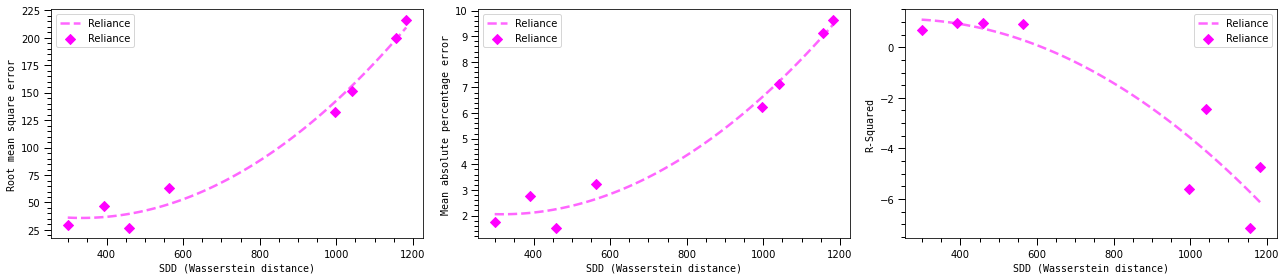

In [33]:
sdd_performance_visualization(sdd_performance_df['Wasserstein_dist'].values,  sdd_performance_df['RMSE'].values, sdd_performance_df['MAPE'].values, sdd_performance_df['R-Squared'].values, label='Reliance')

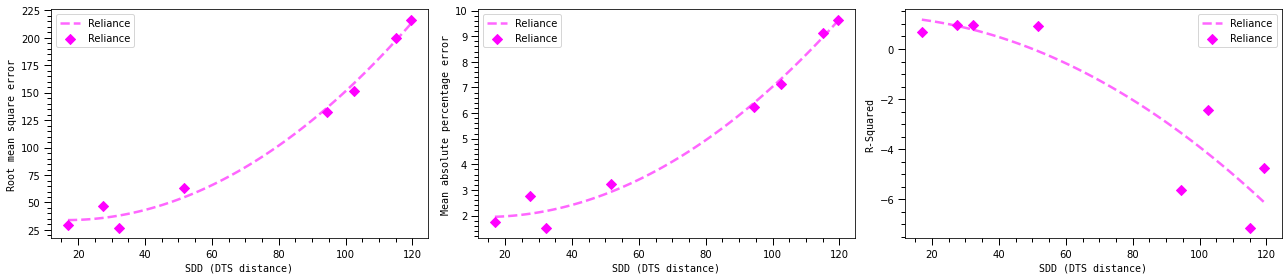

In [34]:
sdd_performance_visualization(sdd_performance_df['DTS_dist'].values, sdd_performance_df['RMSE'].values, sdd_performance_df['MAPE'].values, sdd_performance_df['R-Squared'].values, xlabel='DTS distance', label='Reliance')

As seen in these figures, the performance of both models deteriorate as SDD increases. Figures above demonstrate how model performance (as measured by MAPE, RMSE, and R-squared) decreases as Wasserstein and DTS distances increase.

### Compute StaDRo measure on hold-out dataset

In order to compute StaDRo, we first define $P_{min}$ for every performance metric. The value of $P_{min}$ indicates the minimum acceptable performance that model should exhibit in runtime context. 

The ECDF distance measure is computed for a particular test instance $X^{*}$ against the training set X. StaDRo estimates the model's robustness for test instance $X^{*}$ at a specified minimum performance $P_{min}$ using the equation:


$$StaDRo(X^{*}, P_{min}) = \begin{cases}True \; \; {\dfrac{f(X, X^*)}{d_{P{min}}}} \leq 1 \\\\
                                False \; \; \dfrac{f(X, X^*)}{d_{P_{min}}} > 1 \end{cases}
                                $$

In [35]:
# Define the required minimum performance limit for three performance metrics: RMSE, MAPE, R2
# Note: As RMSE and MAPE are the forecasting error measures, minimum perfoirmance would be an upper bound the error.

MIN_RMSE = 125
MIN_MAPE = 6.0
MIN_R2 = 0.85

In [36]:
stadro_df = sdd_performance_df.iloc[:, [0, 1, 2, 3, -1]]
stadro_df

,Data Instance,RMSE,MAPE,R-Squared,Wasserstein_dist
0,0 : 70,29.628983,1.749787,0.685558,298.587729
1,70 : 140,26.856679,1.518385,0.952918,459.474070
2,140 : 210,47.133102,2.755424,0.944063,392.110418
3,210 : 280,63.627978,3.246228,0.902331,563.165340
4,280 : 350,216.608491,9.647360,-4.736759,1182.599637
5,350 : 420,132.016948,6.219833,-5.616918,996.976089
6,420 : 490,151.742606,7.126105,-2.444127,1042.103199
7,490 : 560,200.172318,9.120893,-7.141950,1155.867567


The function compute_roots_from_curve_fit() returns dissimilarity corresponding to minimum Performance. The maximum of the two roots is considered for dissimilarity while computing StaDRo.

In [37]:
# Compute StaDRo from curve fitting

WDFromCurve_1_rmse, WDFromCurve_2_rmse = compute_roots_from_curve_fit(stadro_df['Wasserstein_dist'].values,  stadro_df['RMSE'].values, MIN_RMSE)
WDFromCurve_rmse = max(WDFromCurve_1_rmse, WDFromCurve_2_rmse)

WDFromCurve_1_mape, WDFromCurve_2_mape = compute_roots_from_curve_fit(stadro_df['Wasserstein_dist'].values,  stadro_df['MAPE'].values, MIN_MAPE)
WDFromCurve_mape = max(WDFromCurve_1_mape, WDFromCurve_2_mape)

WDFromCurve_1_r2, WDFromCurve_2_r2 = compute_roots_from_curve_fit(stadro_df['Wasserstein_dist'].values,  stadro_df['R-Squared'].values, MIN_R2)
WDFromCurve_r2 = max(WDFromCurve_1_r2, WDFromCurve_2_r2)

stadro_df['rmse_ratio'] = np.round((stadro_df['Wasserstein_dist'] / WDFromCurve_rmse), 2)
stadro_df['mape_ratio'] = np.round((stadro_df['Wasserstein_dist'] / WDFromCurve_mape), 2)
stadro_df['r2_ratio'] = np.round((stadro_df['Wasserstein_dist'] / WDFromCurve_r2), 2)

stadro_df.loc[stadro_df['rmse_ratio'] <= 1.00  , 'Robust_rmse'] = 'True'
stadro_df.loc[stadro_df['rmse_ratio'] > 1.00, 'Robust_rmse'] = 'False'

stadro_df.loc[stadro_df['mape_ratio'] <= 1.00  , 'Robust_mape'] = 'True'
stadro_df.loc[stadro_df['mape_ratio'] > 1.00, 'Robust_mape'] = 'False'

stadro_df.loc[stadro_df['r2_ratio'] <= 1.00  , 'Robust_r2'] = 'True'
stadro_df.loc[stadro_df['r2_ratio'] > 1.00, 'Robust_r2'] = 'False'

In [38]:
stadro_df

,Data Instance,RMSE,MAPE,R-Squared,Wasserstein_dist,rmse_ratio,mape_ratio,r2_ratio,Robust_rmse,Robust_mape,Robust_r2
0,0 : 70,29.628983,1.749787,0.685558,298.587729,0.32,0.31,0.70,True,True,True
1,70 : 140,26.856679,1.518385,0.952918,459.474070,0.49,0.48,1.08,True,True,False
2,140 : 210,47.133102,2.755424,0.944063,392.110418,0.42,0.41,0.92,True,True,True
3,210 : 280,63.627978,3.246228,0.902331,563.165340,0.60,0.59,1.33,True,True,False
4,280 : 350,216.608491,9.647360,-4.736759,1182.599637,1.26,1.25,2.79,False,False,False
5,350 : 420,132.016948,6.219833,-5.616918,996.976089,1.06,1.05,2.35,False,False,False
6,420 : 490,151.742606,7.126105,-2.444127,1042.103199,1.11,1.10,2.46,False,False,False
7,490 : 560,200.172318,9.120893,-7.141950,1155.867567,1.23,1.22,2.72,False,False,False


The table above is an example of StaDRo using Reliance data. When compared to prior data, dissimilarity (Wasserstein distance) increases to 1182.60 between 280-350th time step. As the chosen $P_{min}$ for RMSE is 125, the ratio of dissimilarity corresponding to RMSE of 216.608 to that corresponding to 125 is greater than 1 for this data instance. As a result, StaDRo measure return False in this regime for a LSTM model. This analysis holds true for MAPE measure as well.

R2 values can be negative, therefore choosing a negative Pmin is unsuitable in real-world contexts. However, choosing a value between 0 and 1 may result in a few false alarms because the model can capture data variance especially well in some regions when dissimilarity is greater. R2 is not measure of prediction accuracy of the fitted model. This work employs the R2 measure and analyzes its relationship with SDD, which may be relevant in instances where the R2 measure is used to evaluate forecasting models.

The column for Wasserstein distance indicate that data encountered from 280th time step onward is more dissimilar than training data. This is beneficial to determine OOD instances. As indicated by StaDRo measure, the LSTM model is not robust in this regime.  

The proposed StaDRo is a model-agnostic measure that considers rate of change of dissimilarity and enables runtime monitoring of ML models. Machine learning algorithms that are designed to be robust to distributional shifts may benefit from the proposed StaDRo metric by using it as additional validation of robustness.

Future works in the direction of StaDRo measure include applying the measure to multivariate time series and extending it to account for adversarial examples.